# A demonstration of some basic computations using `infotopo` package

* Link: http://github.com/leihuang/infotopo
* Reference: https://github.com/leihuang/infotopo/blob/master/docs/PhDThesisLeiHuang.pdf (Section 2.7)
* About `SloppyCell`, around which much of the computation on reaction networks in `rxnnet` is wrapped: http://sloppycell.sourceforge.net/user.pdf


In [1]:
from __future__ import division, print_function, absolute_import
from collections import OrderedDict as OD

from rxnnet import network, mca, experiments, util
from infotopo import residual, fitting, sampling

In [2]:
net = network.Network('path3mmh')
net.add_compartment(id='env')
net.add_compartment(id='cell')
net.add_species(id='C1', compartment='env', initial_value=2, is_constant=True)
net.add_species(id='C2', compartment='env', initial_value=0.5, is_constant=True)
net.add_species(id='X1', compartment='cell', initial_value=1)
net.add_species(id='X2', compartment='cell', initial_value=1)
net.add_reaction(id='R1', eqn='C1<->X1', ratelaw='V1f/K1C1*(C1-X1/KE1)/(1+C1/K1C1+X1/K1X1)', 
                 p=OD([('V1f',1),('K1C1',1),('K1X1',1),('KE1',5)]))
net.add_reaction(id='R2', eqn='X1<->X2', ratelaw='V2f/K2X1*(X1-X2/KE2)/(1+X1/K2X1+X2/K2X2)', 
                 p=OD([('V2f',1),('K2X1',1),('K2X2',1),('KE2',4)]))
net.add_reaction(id='R3', eqn='X2<->C2', ratelaw='V3f/K3X2*(X2-C2/KE3)/(1+X2/K3X2+C2/K3C2)', 
                 p=OD([('V3f',1),('K3X2',1),('K3C2',1),('KE3',1)]))
for KEid in ['KE1', 'KE2', 'KE3']:
    net.set_var_optimizable(KEid, False)

In [3]:
p = net.p.randomize(seed=0, sigma=1)

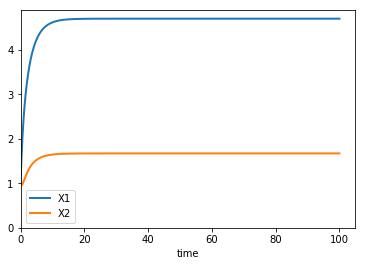

In [17]:
traj = net.get_traj((0,100), p=p)
traj.plot()

In [5]:
# get steady-state concentrations
s = net.get_s(p=p)
print(s)

X1    4.704357
X2    1.673599
dtype: float64


In [6]:
# Structural calculation: get stoichiometry matrix and steady-state flux vectors
print(net.N, '\n\n', net.K)

    R1  R2  R3
X1   1  -1   0
X2   0   1  -1 

     J1
R1   1
R2   1
R3   1


In [7]:
# MCA calculation: get flux control matrix (rows should sum up to one by the Summation Theorem of MCA)
nCJ = mca.get_flux_control_matrix(net, p=p, normed=True)
print(nCJ, '\n')
print(nCJ.sum(axis=1))

          R1        R2        R3
R1  0.276937  0.372677  0.350386
R2  0.276937  0.372677  0.350386
R3  0.276937  0.372677  0.350386 

R1    1.0
R2    1.0
R3    1.0
dtype: float64


At the core of **information geometry** and **information topology** is the abstraction of mathematical models as functions ($f$) that map from parameters ($p$) to predictions ($y$): 

$$f: p \mapsto y, \text{ or } y=f(p)$$.

With an $f$ specified, one can do a number of standard modeling tasks:
* **Parameter estimation**: $p^\ast = f^{-1}(y)$ with uncertainty estimated as $\delta p=\left(Df^{-1}\right) \delta y$
* **Ensemble sampling**: eg, sampling posterior distribution $f(p|y)\propto f(p) f(y|p)$
* **Model comparison** (which includes **model selection** and **model reduction**): given $f_1$ and $f_2$ that both predict $y$, how does one compare them and which one is better?

In [8]:
# get experiments objects that specify the model predictions (that is, y)
expts_xc = experiments.get_experiments(net.xids, ['C1','C2'], 
                                       us=util.get_product(*[[1,2,3]]*2))
expts_jc = experiments.get_experiments(net.Jids[0], ['C1','C2'], 
                                       us=util.get_product(*[[1,2,3]]*2))

In [18]:
expts_xc

,condition,varids,times
experiment,,,
1,"((C1, =, 1), (C2, =, 1))","[X1, X2]",[inf]
2,"((C1, =, 1), (C2, =, 2))","[X1, X2]",[inf]
3,"((C1, =, 1), (C2, =, 3))","[X1, X2]",[inf]
4,"((C1, =, 2), (C2, =, 1))","[X1, X2]",[inf]
5,"((C1, =, 2), (C2, =, 2))","[X1, X2]",[inf]
6,"((C1, =, 2), (C2, =, 3))","[X1, X2]",[inf]
7,"((C1, =, 3), (C2, =, 1))","[X1, X2]",[inf]
8,"((C1, =, 3), (C2, =, 2))","[X1, X2]",[inf]
9,"((C1, =, 3), (C2, =, 3))","[X1, X2]",[inf]


In [9]:
# combine model objects and experiments objects to get predict objects (that is, f)
pred_xc = net.get_predict(expts_xc, tol=1e-13)
pred_jc = net.get_predict(expts_jc, tol=1e-13)
pred = pred_xc + pred_jc

**Spectrum** refers to the list of **singular values** of $Df$ and the number of zeros tells how well-conditioned is $f$.

Here, the presence of two numerical zeros mean that $f$ has two degrees of **structural nonidentifiability** if we use only steady-state concentration data, and that goes away if we *also* use steady-state flux data. 

In [10]:
print(pred_xc.get_spectrum(p))
print(pred.get_spectrum(p))

[  1.20905442e+01   4.93033641e+00   2.52758635e-01   1.39687397e-01
   1.01009238e-01   3.91820667e-02   8.71208005e-03   2.56166801e-16
   1.30507017e-16]
[  1.22337512e+01   4.93141522e+00   8.37274936e-01   2.49733197e-01
   1.38769116e-01   6.64837163e-02   3.77714875e-02   9.85294255e-03
   3.33095961e-03]


In [11]:
# generating simulation data
dat = pred.get_dat(p=p)
print(dat)

                                            Y  sigma
((C1, =, 1), (C2, =, 1)), X1, inf    2.946751    1.0
((C1, =, 1), (C2, =, 1)), X2, inf    1.810122    1.0
((C1, =, 1), (C2, =, 2)), X1, inf    3.415678    1.0
((C1, =, 1), (C2, =, 2)), X2, inf    2.923024    1.0
((C1, =, 1), (C2, =, 3)), X1, inf    3.719251    1.0
((C1, =, 1), (C2, =, 3)), X2, inf    3.971140    1.0
((C1, =, 2), (C2, =, 1)), X1, inf    5.312293    1.0
((C1, =, 2), (C2, =, 1)), X2, inf    2.366553    1.0
((C1, =, 2), (C2, =, 2)), X1, inf    6.115603    1.0
((C1, =, 2), (C2, =, 2)), X2, inf    3.616832    1.0
((C1, =, 2), (C2, =, 3)), X1, inf    6.658750    1.0
((C1, =, 2), (C2, =, 3)), X2, inf    4.772198    1.0
((C1, =, 3), (C2, =, 1)), X1, inf    7.452233    1.0
((C1, =, 3), (C2, =, 1)), X2, inf    2.820369    1.0
((C1, =, 3), (C2, =, 2)), X1, inf    8.545576    1.0
((C1, =, 3), (C2, =, 2)), X2, inf    4.179453    1.0
((C1, =, 3), (C2, =, 3)), X1, inf    9.301372    1.0
((C1, =, 3), (C2, =, 3)), X2, inf    5.422006 

In [12]:
# make a residual object that contains the predict object and data, 
# and do the fitting (using Levenberg-Marquardt algorithm)
res = residual.Residual(pred=pred, dat=dat)
fit = fitting.fit_lm_scipy(res, p0=p.randomize(sigma=0.2))

In [13]:
fit.p

V1f     5.836039
K1C1    1.492059
K1X1    2.661096
V2f     9.401725
K2X1    6.472471
K2X2    0.376334
V3f     2.585938
K3X2    0.859541
K3C2    0.901930
dtype: float64

In [14]:
# confirm that the best fit parameter recovers the original parameter used for generating the simulation data
fit.p - p

V1f    -2.842171e-14
K1C1   -5.107026e-15
K1X1    1.376677e-14
V2f     9.237056e-14
K2X1    1.012523e-13
K2X2    2.164935e-15
V3f     3.552714e-15
K3X2    1.776357e-15
K3C2   -1.776357e-15
dtype: float64

In [15]:
# generating ensembles
ens = sampling.sampling(res, 1000, stepscale=0.1, interval_print_step=100)

100
200
300
400
500
600
700
800
900
1000


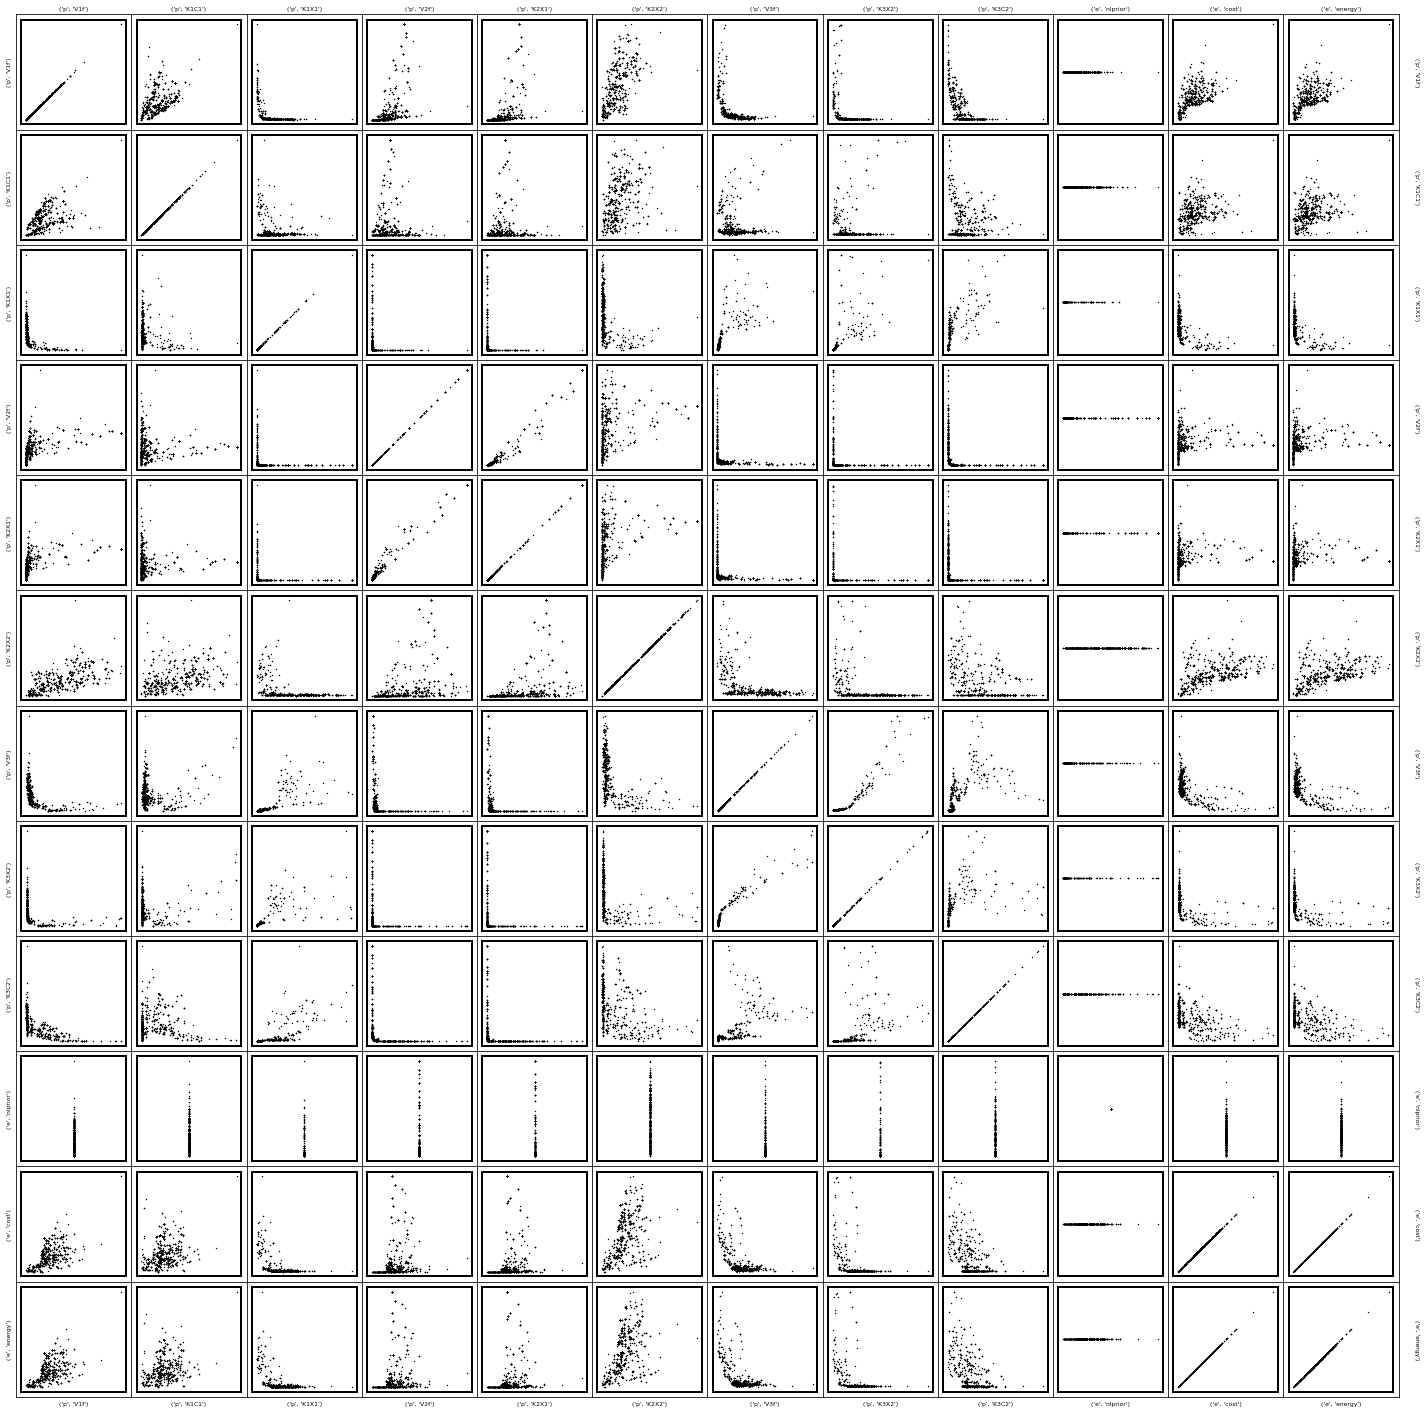

In [16]:
# scatter-plot the ensembles
ens.scatter()